<a href="https://colab.research.google.com/github/arielmeragelman/PracticaProfesionalizante2/blob/Sebastian-documentacion/clasificar_imagenes_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
#assert float(tf.__version__[:3]) >= 2.3 # el notebook incluida un chequeo de version, no se condice por lo que ignoramos por ahora

import os
import numpy as np
import matplotlib.pyplot as plt
import random
import shutil
from google.colab import drive
 


In [3]:

# Generamos la estructura de carpetas

try:
  os.mkdir("train")
  os.mkdir("test")

  os.mkdir("train/blurImage")
  os.mkdir("train/sharpImage")

  os.mkdir("test/blurImage")
  os.mkdir("test/sharpImage")
except:
  print("Directorios ya existen")

# Montamos la carpeta del drive donde tenemos el dataset
drive.mount('/content/drive')  

Mounted at /content/drive


In [6]:

# Defino ubicación del dataset montado
path = "/content/drive/MyDrive/blur_dataset_scaled"
listImage = []
# Listamos todas las imagenes que estan "bien" en el folder de sharp
for i in os.listdir(path):
    
    if i=="sharp" or i=="blur_dataset_scaled":
        
        continue
        
    for j in os.listdir(path+"/"+i):
        
        
        try:
        
            if j.split(".")[1]!="JPG" and j.split(".")[1]!="jpg" and j.split(".")[1]!="jpeg":

                pass
        except:
            
            pass
        # Creamos una lista con el nombre/path de las imagenes que estan "bien"        
        listImage.append(path+"/"+i+"/"+j)
        
# Reordenamos al azar dentro del array los nombres de archivos
random.shuffle(listImage)

# Separamos los nombres de archivos en 2 grupos (testeo y train)
train_blur = listImage[0:500]
test_blur = listImage[600:]

print(len(train_blur))
print(len(test_blur))

500
100


In [7]:
# Listamos todas las imagenes que estan "mal" en el folder de blur
for i in train_blur:
    
    image_name = i.split("/")
    image_name = image_name[len(image_name)-1]
    
    try:
        # copiamos las imagenes de entrenamiento borrosas
        shutil.copyfile(i, "train/blurImage/"+image_name)
        
    except:
        
        pass

In [8]:
# Validamos el tamaño del dataset borroso de entrenamiento
len(os.listdir("train/blurImage/"))

500

In [9]:
# Copiamos los archivos que estan "mal" para testeo en otra carpeta
for i in test_blur:
    
    image_name = i.split("/")
    image_name = image_name[len(image_name)-1]

        
    shutil.copyfile(i, "test/blurImage/"+image_name)

In [10]:
# Validamos el tamaño del dataset de testeo borroso
len(os.listdir("test/blurImage/"))

100

In [12]:
# Creamos una lista de imagenes "correctas" 
path = "/content/drive/MyDrive/blur_dataset_scaled"
listImage = []

for i in os.listdir(path):
    
    if i!="sharp":
        
        continue
    
    for j in os.listdir(path+"/"+i):

        
        try:
        
            if j.split(".")[1]!="JPG" and j.split(".")[1]!="jpg" and j.split(".")[1]!="jpeg":

                pass
        except:
            
            pass
        
        listImage.append(path+"/"+i+"/"+j)
        
# Reordenamos la lista de imagenes de forma que sea aleatorea su distribución
random.shuffle(listImage)
train_sharp = listImage[0:300]
test_sharp = listImage[300:]
print(len(train_sharp))
print(len(test_sharp))

300
50


In [16]:
# copiamos en la carpeta de entrenamiento de imagenes correctas
for i in train_sharp:
    
    image_name = i.split("/")
    image_name = image_name[len(image_name)-1]
    
    try:
        
        shutil.copyfile(i, "train/sharpImage/"+image_name)

        
    except:
        
        pass

In [17]:
# validamos el tamaño de la carpeta de entrenamiento de imagenes correctas
len(os.listdir("train/sharpImage/"))

300

In [20]:
# copiamos en la carpeta de testing de imagenes correctas
for i in test_sharp:
    
    image_name = i.split("/")
    image_name = image_name[len(image_name)-1]
    
    try:
        
        shutil.copyfile(i, "test/sharpImage/"+image_name)
        
    except:
        
        pass

In [21]:
# validamos el tamaño de la carpeta de testing de imagenes correctas

len(os.listdir("test/sharpImage/"))


50

In [23]:
# Iniciamos el proceso de entrenamiento - Definiciones del modelo
IMAGE_SIZE = 600
BATCH_SIZE = 32
path = "."


# Generate batches of tensor image data with real-time data augmentation. - funcion antigua se debe evaluar reemplazar

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)
'''
Intentar entrenar el modelo requiere de mucha memoria que no tenemos, por lo que es necesario dividir el proceso de entrenamiento en bloques (o batchs, en inglés) de menor tamaño de imágenes.
Para ello, Keras cuenta con la clase ImageDataGenerator, que nos permite generar dichos bloques, además de realizar la técnica llamada data augmentation.
Data augmentation
La idea es que, cuando se dispone de un número de imágenes relativamente pequeño, podemos aumentar el número modificando las imágenes originales (haciendo zoom, escalado, flip horizontal, etc) 
Fuente: https://www.enmilocalfunciona.io/tratamiento-de-imagenes-usando-imagedatagenerator-en-keras/

'''


# toma los datos de ingreso de imagenes para el entrenamiento y genera un objeto iterable con los datos de las imagenes y el label correspondiente
train_generator = datagen.flow_from_directory(
    path+"/train",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

# toma los datos de ingreso de imagenes para el testing y genera un objeto iterable con los datos de las imagenes y el label correspondiente
val_generator = datagen.flow_from_directory(
    path+"/test",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 640 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [24]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

((30, 600, 600, 3), (30, 2))

In [25]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')
base_model.trainable = False


# This function returns a Keras image classification model, optionally loaded with weights pre-trained on ImageNet.




9406464/9406464 [==============================] - 0s 0us/step


In [26]:
'''
It is one of the models that is used to investigate varied types of neural networks where the model gets in one input as feedback and expects an output as desired. The Keras API and library is incorporated with a sequential model to judge the entire simple model not the complex kind of model. It passes on the data and flows in sequential order from top to bottom approach till the data reaches at end of the model.
Keras sequential class is one of the important class as part of the entire Keras sequential model. This class helps in creating a cluster where a cluster is formed with layers of information or data that flows with top to bottom approach having a lot of layers incorporated with tf.Keras. a model where most of its features are trained with algorithms that provide a lot of sequence to the model.
'''

# Se define el modelo propiamente dicho
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(units=2, activation='softmax')
])

In [27]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 19, 19, 1280)     2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 17, 17, 32)        368672    
                                                                 
 dropout (Dropout)           (None, 17, 17, 32)        0         
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 2,626,722
Trainable params: 368,738
Non-tr

In [29]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))


Number of trainable weights = 4


In [30]:
# Entrenamos el modelo
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=5,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/5
20/20 [==============================] - 322s 16s/step - loss: 0.7800 - accuracy: 0.8016 - val_loss: 0.0747 - val_accuracy: 0.9667
Epoch 2/5
20/20 [==============================] - 299s 15s/step - loss: 0.1512 - accuracy: 0.9359 - val_loss: 0.0101 - val_accuracy: 1.0000
Epoch 3/5
20/20 [==============================] - 310s 15s/step - loss: 0.0681 - accuracy: 0.9766 - val_loss: 0.0083 - val_accuracy: 1.0000
Epoch 4/5
20/20 [==============================] - 298s 15s/step - loss: 0.0446 - accuracy: 0.9844 - val_loss: 0.0051 - val_accuracy: 1.0000
Epoch 5/5
20/20 [==============================] - 311s 15s/step - loss: 0.0230 - accuracy: 0.9953 - val_loss: 0.0040 - val_accuracy: 1.0000


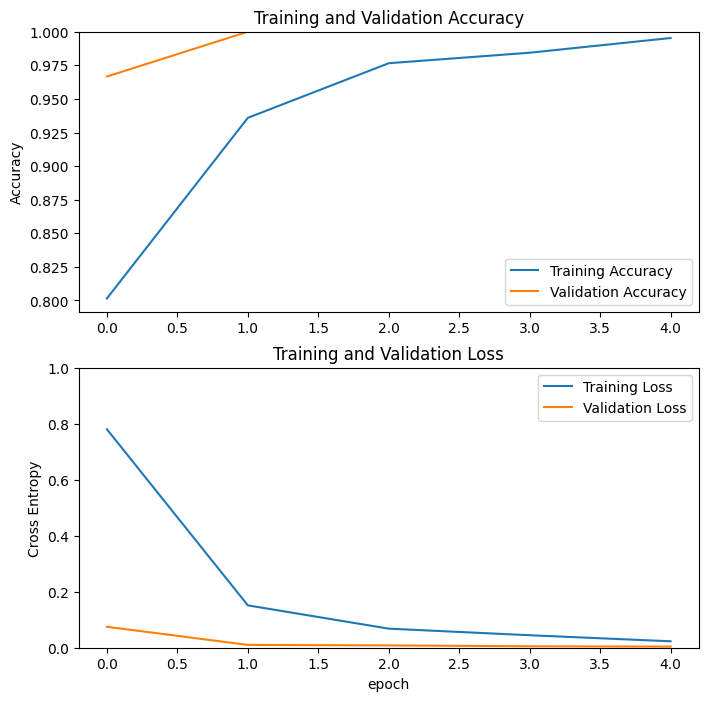

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

'''
Una función de pérdida, o Loss function, es una función que evalúa la desviación entre las predicciones realizadas por la red neuronal y los valores reales de las observaciones utilizadas durante el aprendizaje. Cuanto menor es el resultado de esta función, más eficiente es la red neuronal
'''
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [32]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('mobilenet_v2_1.0_224.tflite', 'wb') as f:
  f.write(tflite_model)

In [33]:
train_generator[0][0].shape

(32, 600, 600, 3)

1/1 [==============================] - 12s 12s/step


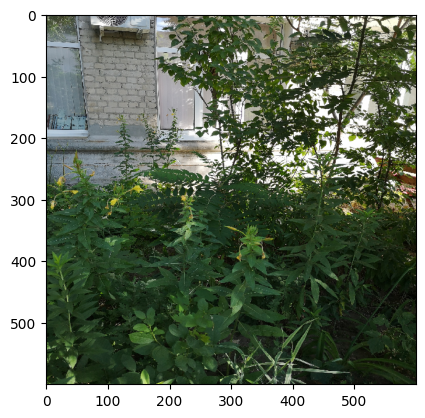

Label : sharp


In [41]:
imagen_predecir=4
sn = model.predict(train_generator[imagen_predecir][0])
count = 5
plt.imshow(train_generator[imagen_predecir][0][count])
plt.show()

if sn[count][0]> sn[count][1]:
    
    print("Label : blur")
    
else:
    
    print("Label : sharp")

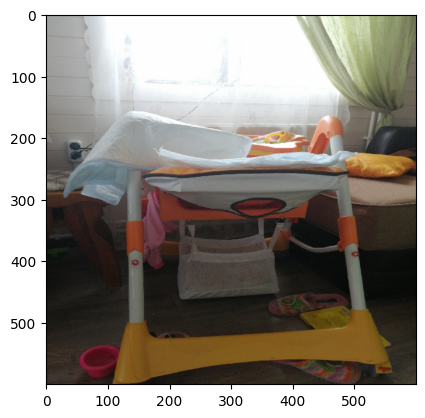

Label : blur


In [42]:
count = 0
plt.imshow(train_generator[11][0][count])
plt.show()

if sn[count][0]> sn[count][1]:
    
    print("Label : blur")
    
else:
    
    print("Label : sharp")